# Advanced topics in recommender systems- EX2
---------

In [1]:
#!pip install scikit-optimize

## imports

In [2]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skopt
from skopt import gp_minimize
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence
import os.path
from tqdm import tqdm
from math import exp
from scipy.special import expit
np.random.seed(42)

## class of MF with bias

In [3]:
# creating new class for the Matrix Factorization
class MatrixFactorizationWithBiases:
    # the class get seed, hidden_dimension and option to print the metrics
    def __init__(self, seed, hidden_dimension, print_metrics=True):
        # define attricutes or seed with the inputs
        self.h_len = hidden_dimension
        np.random.seed(seed)
        self.print_metrics = print_metrics
        # initialize another attributes we need for MF
        self.results = {}
        self.user_map = None
        self.item_map = None
        self.global_bias = None
        self.item_biases = None
        self.x_u = None
        self.y_i = None
        self.b_i = None   # check
        self.lamda_bi = None
        self.lamda_xu = None
        self.lamda_yi = None
        self.epochs = None

    # conert results to dataframe from dictionary
    def get_results(self):
        return pd.DataFrame.from_dict(self.results)
    
    
    def record(self, epoch, **kwargs):
        epoch = "{:02d}".format(epoch)
        temp = f"| epoch   # {epoch} :"
        # for each parameter save the key
        for key, value in kwargs.items():
            key = f"{key}"
            # if key is not in the dictionary initialize it with empty list 
            if not self.results.get(key):
                self.results[key] = []
            # append the value
            self.results[key].append(value)
            val = '{:.4}'.format(value)
            result = "{:<32}".format(F"  {key} : {val}")
            temp += result
        print(temp)
        

    def set_params(self, **kwargs):
        # for each key and value set the value in the key attribute
        for key, value in kwargs.items():
            setattr(self, key, value)

    def fit(self, train, user_map, item_map, validation= None):
        pass
    
 
    def l2_loss(self):
        # initialize loss to 0
        loss = 0
        # create list of parameters 
        parameters = [self.b_i, self.x_u, self.y_i]
        # create list of parameters of regularization
        regularizations = [self.l2_bi, self.l2_xu, self.l2_yi]
        # compute the loss 
        for i in range(len(parameters)):
            loss += regularizations[i] * np.sum(np.square(parameters[i]))
        # return the total loss (regularization + prediction error)
        return loss
    
    def sigmoid_inner_scalar(self, user, item):
        # caculatr the sigmoid by the equation
        return self.item_biases[item] + self.x_u[user, :].dot(self.y_i[item, :].T)

 
    def accuracy_vs_epoch(self,epoch):
        # get the train and validation accuracy
        train_accuracy = self.results['train_percent_right']
        validation_accuracy = self.results['validation_percent_right']
        # define list with all the epochs
        epochs = [i for i in range(1, epoch+1)]
        # plot train accuracy and valisation accuracy vs epochs
        plt.plot(epochs, train_accuracy, label='Train Accuracy')
        plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
        # add xticks, legend and labels to x,y axis
        plt.xticks(np.arange(1, epoch+1, step=1))
        plt.legend(loc ='upper right')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.show()

## class of config

In [4]:
# for creating the parameters for BPR
class Config:
    def __init__(self, **kwargs):
        self._set_attributes(kwargs)

    def _set_attributes(self, kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

    def add_attributes(self, **kwargs):
        self._set_attributes(kwargs)

## functions for running the models

In [5]:
def preprocess_for_mf(train, validation=None):
    # learn the indices of the train set
    # create dictionary with indeces and values of items
    dict_item = {k: v for v, k in enumerate(train[ITEM_COL].unique())}
    # create dictionary with indeces and values of users
    dict_user = {k: v for v, k in enumerate(train[USER_COL].unique())}
    # mapping from the old indices (for items and users) to the new ones
    train[ITEM_COL] = train[ITEM_COL].map(dict_item)
    train[USER_COL] = train[USER_COL].map(dict_user)

    # if we send validation set
    if validation is not None:
        # mapping from the old indices (for items and users) to the new ones for the validation set too
        validation[ITEM_COL] = validation[ITEM_COL].map(dict_item)
        validation[USER_COL] = validation[USER_COL].map(dict_user)
        # all the indexes that are not appear in the train set but indeed in the validation set to -1
        validation.fillna(-1, inplace=True)
        # change valudation to integers
        validation = validation.astype('int64')
        return train,validation,dict_user,dict_item
    return train, dict_user, dict_item


def run_exp(model, train, user_map, item_map, validation):
    # if need to search the best parameters
    if HYPER_PARAM_SEARCH:
        # save current state after each iteration
        checkpoint_saver = CheckpointSaver(CHECKPOINT_NAME)
        # optimize the hyper paremters
        res_gp = gp_minimize(objective, space, n_calls=HYPER_PARAM_SEARCH_N_ITER, random_state=SEED, 
                             callback=[checkpoint_saver])
        # store an skopt optimization result into a file.
        skopt.dump(res_gp, HYPER_PARAM_FILE_NAME, store_objective=False)
        # plot the convergence
        plot_convergence(res_gp)
    # if do not need to search
    else:
        # fit the model
        model.fit(train, user_map, item_map, validation)
        # get  measures
        results = model.calculate_precision_at_k(train, validation)
        # print the results
        print(results)

----------
# SGD Class for early stopping

In [6]:
class SgdEarlyStopping:
    # get number of iterations for stop condition and minimum epoch
    def __init__(self, n_iter=3, min_epoch=6):
        # n_iter- if accuracy is decreasing for n_iter then stop
        # min_epoch- don't stop before min_epcoch
        # initializr parameters
        self.n_iter = n_iter
        self.last_value = 0
        self.last_last_value = 0
        self.consecutive_decreasing_acc = 0
        self.min_epoch = min_epoch
    
    # def function for stop
    def stop(self, epoch, error):
        # check if epoch is bigger than the minimum epoch
        if epoch >= self.min_epoch:
            # if the accuracy is lower than the last value
            if error < self.last_value:
                # increase by 1 the number of times we had lower accuracy
                self.consecutive_decreasing_acc += 1
            # if the accuracy is not lower, set to zero
            else:
                self.consecutive_decreasing_acc = 0
            # check if the accuracy decrease for 3 times at least and return True
            if self.consecutive_decreasing_acc >= self.n_iter:
                return True
        # if not stop change the values of  last value and last last value
        self.last_last_value = self.last_value
        self.last_value = error
        return False

----------
# BPR Class

In [25]:
# create class for BPR only for SGD that heiress from the class MatrixFactorizationWithBiases
class BPRMatrixFactorizationWithBiasesSGD(MatrixFactorizationWithBiases):
    def __init__(self, config):
        # initialization parameters of the model
        super().__init__(config.seed, config.hidden_dimension, config.print_metrics)
        self.n_users = config.n_users
        self.n_items = config.n_items
        self.lr_xu= config.lr_xu
        self.lr_yi = config.lr_yi
        self.lr_bi = config.lr_bi
        self.negative_sampler = None
        self.early_stopping = None
        self.l2_xu = config.l2_xu
        self.l2_yi = config.l2_yi
        self.l2_bi = config.l2_bi
        self.epochs = config.epochs
        self.results = {}
        self.negative_sampler_type = config.negative_sampler_type
        np.random.seed(SEED)
        self.error = None
    
    # initialization of model's weights
    def weight_init(self, user_map, item_map):
        # define user map and item map
        self.user_map, self.item_map = user_map, item_map
        # initialize x_u, y_i by random numbers from normal distribution
        self.x_u = np.random.normal(scale=0.2 / self.h_len, size=(self.n_users, self.h_len))
        self.y_i = np.random.normal(scale=0.2 / self.h_len, size=(self.n_items, self.h_len))
        # initialize the biases of items to 0 array
        self.b_i = np.zeros(self.n_items)
    
    # define fit function 
    def fit(self, train, user_map, item_map, validation=None):
        # initialize the results
        self.results = {}
        # call to negative sampler class for sampling negative items
        self.negative_sampler = NegativeSampler(train, method=self.negative_sampler_type)
        self.negative_sampler.create_negative_samples(train)
        # create object of early stopping
        self.early_stopping = SgdEarlyStopping()
        # initialize parameters
        self.weight_init(user_map, item_map)
    
        # for each epoch 
        for epoch in range(1, self.epochs + 1):
            print('epoch:',epoch)
            # get the negative samples
            train_with_negative_samples = self.negative_sampler.get(epoch)
            #t2= pd.DataFrame(train_with_negative_samples)
            #print (t2[t2.isna().any(axis=1)])
            # shffuel the train 
            np.random.shuffle(train_with_negative_samples)
            # apply run_epoch with the train data (calculate error and updating parameters)
            self.run_epoch(train_with_negative_samples, epoch)
            # calculate measures for train set
            train_percent_right, train_log_likelihood = self.percent_right_and_log_likelihood(train_with_negative_samples)
            train_objective = train_log_likelihood - self.l2_loss()
            # define dictionary for parameters of objective and precent of right
            convergence_params = {'train_objective': train_objective, 'train_percent_right': train_percent_right}
            # if we have validation
            if validation is not None:
                # calculate measures for validation set
                validation_percent_right, validation_log_likelihood = self.percent_right_and_log_likelihood(validation.values)
                validation_objective = validation_log_likelihood - self.l2_loss()
                # set the error to validation error
                self.error = validation_percent_right
                # append to the dictionary parameters of validation...
                convergence_params.update({'validation_objective': validation_objective, 'validation_percent_right': validation_percent_right})
                # check if need to stop (by the current epoch and validation error)
                if self.early_stopping.stop(epoch, validation_percent_right):
                    # update the results with the errors value
                    self.record(epoch, **convergence_params)
                     # update the error and break
                    self.error = self.early_stopping.last_last_value
                    break
            # update the results with the errors value
            self.record(epoch, **convergence_params)
        # if need to search parameters plot train and validation error vs epoch
        if HYPER_PARAM_SEARCH:
            self.accuracy_vs_epoch(epoch)
        # return error
        return self.error


    def run_epoch(self, data, epoch):
        # for each row in tha data
        for row in data:
            # get the values in the row (user, item_positive, item_negative)
            u, i_positive, i_negative = row
            # convert float to int for slicing
            #print ('u', u, type(u), 'i_positive', i_positive, type(i_positive),'i_negative', i_negative, type(i_negative) )
            u = int(u)
            i_positive = int(i_positive)
            i_negative = int(i_negative)
            #print ('u', u, type(u), 'i_positive', i_positive, type(i_positive),'i_negative', i_negative, type(i_negative) )
            #print ('----------------------------------')
            # compute prediction error
            error = 1 - self.sigmoid(self.sigmoid_inner_scalar_pair(u, i_positive, i_negative))
            # update all parameters
            self.b_i[i_positive] += self.lr_bi * (error - self.l2_bi * self.b_i[i_positive])
            self.b_i[i_negative] += self.lr_bi * (-error - self.l2_bi * self.b_i[i_negative])
            self.x_u[u, :] += self.lr_xu * (error * (self.y_i[i_positive, :] - self.y_i[i_negative, :]) - self.l2_xu * self.x_u[u, :])
            self.y_i[i_positive, :] += self.lr_yi * (error * self.x_u[u, :] - self.l2_yi * self.y_i[i_positive, :])
            self.y_i[i_negative, :] +=self.lr_yi * (error * (-self.x_u[u, :]) - self.l2_yi * self.y_i[i_negative, :])
    
    # compute sigmoid
    def sigmoid(self, x):
        try:
            exponent = exp(-x)
        except OverflowError:
            exponent = float('inf')
        return 1 / (1 + exponent)
    
    # compute sigmpid for 2 items by the equation
    def sigmoid_inner_scalar_pair(self, u, i_positive, i_negative):
        # convert float to int for slicing
        u = int(u)
        i_positive = int(i_positive)
        i_negative = int(i_negative)
        return self.x_u[u,:].dot(self.y_i[i_positive, :].T - self.y_i[i_negative, :].T) + self.b_i[i_positive] - self.b_i[i_negative]
    
    def calculate_precision_at_k(self, train, val):
        # get the unique values of items
        unique_items = set([i for i in range(self.n_items)])
        # initialize zeros with the number of users
        ranks_all_items = np.zeros(self.n_users)
        # intialize zeros with the number of users- for items the user didn't rank
        ranks_items_user_did_not_rank = np.zeros(self.n_users)
        # for each user
        for user in range(self.n_users):
            # get the users' items from the validation set
            user_validation_item = val[val[USER_COL] == user][POSITIVE_COL].values[0]
            # get the items that the user ranked in the training set
            user_unique_items = set(train[train[USER_COL] == user][ITEM_COL])
            # get a list of the items that are in the validation set but the user didn't rank them on the training set
            user_items_did_not_rank = list(unique_items.difference(user_unique_items))
            # calc by logistic sigmoid
            relative_ranks = pd.Series(expit(self.y_i.dot(self.x_u[user, :]) + self.b_i))
            # get the rank for items didn't rank and rank in in descending order and get the validation items
            ranks_items_user_did_not_rank[user] = relative_ranks.take(user_items_did_not_rank).rank(ascending=False)[
                user_validation_item]
            
            # update rank for user
            ranks_all_items[user] = relative_ranks.rank(ascending=False)[user_validation_item]
            
        # initialize dictionary for results
        results_dict = {}
        # record measures in the dictionary
        for k in K_LIST_FOR_PRECISION_AT_K:
            results_dict[F"precision_at_{k}_all_items"] = np.sum(ranks_all_items <= k) / self.n_users
            results_dict[F"precision_at_{k}_items_user_did_not_rank"] = np.sum(
                ranks_items_user_did_not_rank <= k) / self.n_users
        results_dict[F"mpr_all_items"] = np.mean(ranks_all_items / self.n_items)
        return results_dict

    def percent_right_and_log_likelihood(self, x):
        # convert to int and initilaize log likelihood and counter
        x = x.astype(int)
        log_likelihood = 0
        counter = 0
        # for each row
        for row in x:
            # get the user and the 2 items
            u, i_positive, i_negative = row
            # get the prediction and update the counter if it's larger than 0.5
            prediction = self.sigmoid(self.sigmoid_inner_scalar_pair(u, i_positive, i_negative))
            counter += (prediction > 0.5)
            # add the log likelihood to the summerize likelihood
            log_likelihood += np.log(prediction) 
         # the percentage of the items that we corrected from the whole sampels
        percent_right = counter / x.shape[0]  
        return percent_right, log_likelihood

    def predict_on_test_set(self):
        # read the test data
        test = pd.read_csv(TEST_PATH)
        # initialize predictions
        predictions = []
        # for each row compute the prediction by the conditions
        for _, row in test.iterrows():
            # get the user and 2 items
            user, item1, item2 = self.user_map.get(row[USER_COL]), self.item_map.get(row['Item1'], -1), self.item_map.get(row['Item2'], -1)
            # if item2 is more likely then item1 than 1
            # if the item does not exist we replace it with the mean
            if item1 + item2 == -2:
                print('both items exist in test but not in train')
                # choose random
                prediction = np.random.random_sample()
            elif item1 == -1:
                print('item1 exist in test but not in train')
                prediction = self.sigmoid(self.b_i[item2] - np.mean(self.b_i) + self.x_u[user, :].dot(self.y_i[item2, :].T - np.mean(self.y_i, axis=0)))
            elif item2 == -1:
                print('item2 exist in test but not in train')
                prediction = self.sigmoid(np.mean(self.b_i) - self.b_i[item1] + self.x_u[user, :].dot(np.mean(self.y_i, axis=0) - self.y_i[item1, :].T))
            else:
                prediction = self.sigmoid(self.sigmoid_inner_scalar_pair(user, item2, item1))
            # update the list of predictions
            predictions.append((prediction > 0.5) * 1)
        # update new column with the predictions
        test['Classification'] = predictions
        # save to csv
        test.to_csv(PREDICTION_FILE_NAME, index=False)

------
# Class for negative sampler

In [9]:
#self.negative_sampler = NegativeSampler(train, method=self.negative_sampler_type)
#self.negative_sampler.create_negative_samples(train)

In [10]:
# the calss choose negative samples- proportionally to their item strength
class NegativeSampler:
    def __init__(self, train, method='popularity'):
        # save parameters
        self.method = method  # uniform or popularity
        self.data = train
        # the proportion of  item frequency from all the items in the train set
        self.item_probabilities = None  
        self.path = f"{NEGATIVE_SAMPLES_FILE_NAME}.csv"
        self.positive_samples = None

    def create_negative_samples(self, data):
        # if we had already a file so save it
        if os.path.isfile(self.path) and LOAD_NEGATIVE:
            self.positive_samples = data
        else:
            # create new df with a column for each samples set
            empty_df = pd.DataFrame(columns=[i for i in range(1, N_NEGATIVE_SAMPLES_SETS+1)]) 
            # save to csv
            empty_df.to_csv(self.path, index=False)
            # create the samples and save
            self.create_and_save_negative_samples()

    def get(self, epoch):
        # get the samples in data frame
        negative_samples = pd.read_csv(self.path, usecols=[epoch - 1])
        # add to df a column with the negative samples
        train = self.positive_samples.copy()
        train['negative_samples'] = negative_samples.astype(int)
        return train.values

    def adjust_probabilities(self, p):
        # renormalize for popularity
        p = p / p.sum()  
        # if the methos is uniform set the p 
        if self.method == 'uniform':
            p = pd.Series(1 / p.size, p.index)
        return p

    def create_and_save_negative_samples(self):
        print("Creating negative samples")
        # sort values by the user
        self.data.sort_values(by=USER_COL, inplace=True)
        self.positive_samples = self.data 
        # get the unique items
        unique_items = set(self.data[ITEM_COL].unique())
        # the proportion of the item frequency from all the items in the training set
        self.item_probabilities = (self.data.iloc[:, 1].value_counts() / self.data.shape[0]).to_dict() 
        # adding negative example to each user
        for user in tqdm(self.data[USER_COL].unique(), total=len(self.data[USER_COL].unique())):
            # get the unique items for this user
            user_unique_items = self.data[self.data[USER_COL] == user][ITEM_COL].unique()
            # get the items the user didn't rank
            user_items_did_not_rank = list(unique_items.difference(user_unique_items))
            # set series with probabilities for the items the user didn't rank and adjust it
            p = pd.Series({i: self.item_probabilities[i] for i in user_items_did_not_rank})
            p = self.adjust_probabilities(p)
            # create new data frame for negative samples
            user_negative_samples = pd.DataFrame()
            # get the number of unique items
            user_n_items = len(user_unique_items)
            # a condition for replace
            replace_or_not = len(user_items_did_not_rank) < user_n_items
            # for each sample we want
            for i in range(1, N_NEGATIVE_SAMPLES_SETS):
                # choose negative samples by probabilities
                user_negative_samples[i] = np.random.choice(p.index,
                                                            size=user_n_items,
                                                            replace=replace_or_not, p=p.values)
            # save the samples in csv
            user_negative_samples.to_csv(self.path, mode='a', header=False, index=False)

# Class for validation creator

In [11]:
class ValidationCreator:
    def __init__(self, method):
        # save parameters
        self.method = method # uniform or popularity
        self.train_path = TRAIN_FILE_NAME
        self.validation_path = VALIDATION_FILE_NAME

    def get(self, train):
        # get the train  data and validation if can
        if os.path.isfile(self.train_path) and MF_LOAD_TRAIN_VALIDATION:
            train, validation = pd.read_csv(self.train_path), pd.read_csv(self.validation_path)
        else:
            train, validation = self.split(train)
        # if need to save so save in csv
        if MF_SAVE_TRAIN_VALIDATION:
            train.to_csv(self.train_path, index=False)
            validation.to_csv(self.validation_path, index=False)
            # read them from csv
            train, validation = pd.read_csv(self.train_path), pd.read_csv(self.validation_path)
        return train, validation

    def split(self, data):
        # get probabilities
        item_probabilities = (data[ITEM_COL].value_counts() / data.shape[0]).to_dict()
        # get the unique items
        unique_items = set(data[ITEM_COL].unique())
        # intialize list for validation
        validation = []
        print("Creating train & validation sets")
        train = data.copy()
        # adding negative example to each user
        for user in tqdm(data[USER_COL].unique(), total=len(data[USER_COL].unique())):
            # get the unique items for this user
            user_unique_items = set(data[data[USER_COL] == user][ITEM_COL].unique())
             # get the items the user didn't rank
            user_items_did_not_rank = unique_items.difference(user_unique_items)
            # choose from train sample of item: 1) item rank 2) item didn't rank. then add to validation and remove from the train
            one_did_rank, one_did_not_rank = self.choose_items(user_unique_items, user_items_did_not_rank, item_probabilities)
            validation.append([user, one_did_rank, one_did_not_rank])
            train = train[(train[USER_COL] != user) | ((train[USER_COL] == user) & (train[ITEM_COL] != one_did_rank))]
        # convert the vaildation to dataframe
        validation = pd.DataFrame(validation, columns=[USER_COL, POSITIVE_COL, NEGATIVE_COL])
        return train, validation

    def adjust_probabilities(self, p):
        # renormalize - so sum of probabilities will sum to 1
        p = p / p.sum()  
        if self.method == 'uniform':
             # if the methos is uniform set the p 
            p = pd.Series(1 / p.size, p.index)
        return p

    def choose_items(self, did_rank, did_not_rank, item_probabilities):
        # choose items for the validation set: so 1 is positive so the user rank it and the second negative so didn't rank it
        did_rank, did_not_rank = list(did_rank), list(did_not_rank)
        # intialize list for all samples
        positive_and_negative = []
        # for each item
        for i, items in enumerate([did_rank, did_not_rank]):
            # set series with probabilities for the items the user didn't rank and adjust it
            p = pd.Series({i: item_probabilities[i] for i in items})
            p = self.adjust_probabilities(p)
            # choose samples by probabilities
            positive_and_negative.append(np.random.choice(p.index, p=p.values, size=1)[0])
        return positive_and_negative

----------
## parameters for paths and files

In [12]:
# define the paths for the files
TRAIN_PATH = 'Train.csv'
    
# defiend the names of the columns in ths files
USER_COL = 'UserID'
ITEM_COL = 'ItemID'
POSITIVE_COL = 'positive'
NEGATIVE_COL = 'negative'

# set the number of negative samples and list for all the k we want
N_NEGATIVE_SAMPLES_SETS = 50
K_LIST_FOR_PRECISION_AT_K = [1, 10, 50]


-------
## Implement BPR tuning with uniform method

<b> define parameters for this running and for the tuning

In [13]:
# define method
NEGATIVE_SAMPLER_TYPE = 'uniform'             #  'uniform' ,'popularity'
VALIDATION_CREATOR_SAMPLER_TYPE = 'uniform'   # 'uniform' ,'popularity'
TEST_PATH = 'RandomTest.csv'

# define names for files we need
CHECKPOINT_NAME = f"./checkpoint_{NEGATIVE_SAMPLER_TYPE}.pkl"
HYPER_PARAM_FILE_NAME = f"HyperParamResult_{NEGATIVE_SAMPLER_TYPE}.pkl"

# results by types
NEGATIVE_SAMPLES_FILE_NAME = F"all_negative_samples_{NEGATIVE_SAMPLER_TYPE}"
RESULT_FILE_NAME = F"validation_results_negative_sampler_{NEGATIVE_SAMPLER_TYPE}_validation_type_{VALIDATION_CREATOR_SAMPLER_TYPE}.csv"
TRAIN_FILE_NAME = F"train_validation_type_{VALIDATION_CREATOR_SAMPLER_TYPE}.csv"
VALIDATION_FILE_NAME = F"validation_validation_type_{VALIDATION_CREATOR_SAMPLER_TYPE}.csv"
PREDICTION_FILE_NAME = "random_205948094_207331752_311244636.csv"


In [14]:
# HYPER_PARAM_SEARCH or manual config- set to TRUE to search the best parameters
HYPER_PARAM_SEARCH = True
# number of parameters, seed and the measure for error
HYPER_PARAM_SEARCH_N_ITER = 10
SEED = 42

# Save and load
MF_SAVE_TRAIN_VALIDATION = True  
MF_LOAD_TRAIN_VALIDATION = False
LOAD_NEGATIVE = False

# hyper parameter tuning
BPR_SPACE = [skopt.space.Real(0.01, 0.1, name='lr_xu', prior='uniform'),
             skopt.space.Real(0.01, 0.1, name='lr_yi', prior='uniform'),
             skopt.space.Real(0.01, 0.1, name='lr_bi', prior='uniform'),
             skopt.space.Real(0.001, 0.01, name='l2_xu', prior='uniform'),
             skopt.space.Real(0.001, 0.01, name='l2_yi', prior='uniform'),
             skopt.space.Real(0.001, 0.01, name='l2_bi', prior='uniform'),
             skopt.space.Categorical([20, 24, 28, 32, 36], name='h_len')]
space = BPR_SPACE

CONFIG = Config(
    lr_xu=0.05,
    lr_yi=0.01,
    lr_bi=0.01,
    print_metrics=True,
    hidden_dimension=28,
    l2_xu=0.001,
    l2_yi=0.001,
    l2_bi=0.001,
    epochs=35,
    seed=SEED,
    negative_sampler_type=NEGATIVE_SAMPLER_TYPE,
    validation_creator_sampler_type=VALIDATION_CREATOR_SAMPLER_TYPE)

@skopt.utils.use_named_args(space)
def objective(**params):
    mf.set_params(**params)
    print({i: np.round(v, 3) for i, v in mf.__dict__.items() if i in params.keys()})
    return mf.fit(train.copy(), user_map, item_map, validation.copy())

<b> read files:

In [15]:
# read the csv file (train data)
train = pd.read_csv(TRAIN_PATH)
# appply the preprocess_for_mf function to get train, validation, dictionary for users and dictionary for items
train, user_map, item_map = preprocess_for_mf(train.copy())

<b> "turn on" tuning and run all the model

  0%|                                                                                 | 3/6040 [00:00<04:29, 22.41it/s]

Creating train & validation sets


  0%|                                                                                         | 0/6040 [00:00<?, ?it/s]

{'h_len': 28, 'lr_xu': 0.082, 'lr_yi': 0.027, 'lr_bi': 0.08, 'l2_xu': 0.006, 'l2_yi': 0.005, 'l2_bi': 0.002}
Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [04:58<00:00, 20.24it/s]


epoch: 1
| epoch   # 01 :  train_objective : -3.319e+05    train_percent_right : 0.8514    validation_objective : -2.027e+03  validation_percent_right : 0.8526
epoch: 2
| epoch   # 02 :  train_objective : -3.275e+05    train_percent_right : 0.8523    validation_objective : -2.027e+03  validation_percent_right : 0.8556
epoch: 3
| epoch   # 03 :  train_objective : -2.966e+05    train_percent_right : 0.8704    validation_objective : -1.93e+03  validation_percent_right : 0.8651
epoch: 4
| epoch   # 04 :  train_objective : -2.559e+05    train_percent_right : 0.892     validation_objective : -1.771e+03  validation_percent_right : 0.8786
epoch: 5
| epoch   # 05 :  train_objective : -2.257e+05    train_percent_right : 0.9072    validation_objective : -1.638e+03  validation_percent_right : 0.8965
epoch: 6
| epoch   # 06 :  train_objective : -2.04e+05     train_percent_right : 0.9178    validation_objective : -1.556e+03  validation_percent_right : 0.8997
epoch: 7
| epoch   # 07 :  train_objectiv

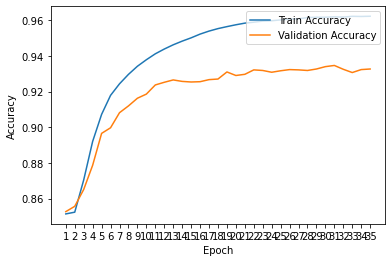

{'h_len': 20, 'lr_xu': 0.04, 'lr_yi': 0.023, 'lr_bi': 0.069, 'l2_xu': 0.002, 'l2_yi': 0.007, 'l2_bi': 0.009}
Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [06:14<00:00, 16.14it/s]


epoch: 1
| epoch   # 01 :  train_objective : -3.361e+05    train_percent_right : 0.8517    validation_objective : -2.098e+03  validation_percent_right : 0.8548
epoch: 2
| epoch   # 02 :  train_objective : -3.336e+05    train_percent_right : 0.8523    validation_objective : -2.096e+03  validation_percent_right : 0.8541
epoch: 3
| epoch   # 03 :  train_objective : -3.316e+05    train_percent_right : 0.8528    validation_objective : -2.099e+03  validation_percent_right : 0.8561
epoch: 4
| epoch   # 04 :  train_objective : -3.194e+05    train_percent_right : 0.8603    validation_objective : -2.062e+03  validation_percent_right : 0.8608
epoch: 5
| epoch   # 05 :  train_objective : -2.866e+05    train_percent_right : 0.8794    validation_objective : -1.956e+03  validation_percent_right : 0.8714
epoch: 6
| epoch   # 06 :  train_objective : -2.562e+05    train_percent_right : 0.8958    validation_objective : -1.827e+03  validation_percent_right : 0.8816
epoch: 7
| epoch   # 07 :  train_objecti

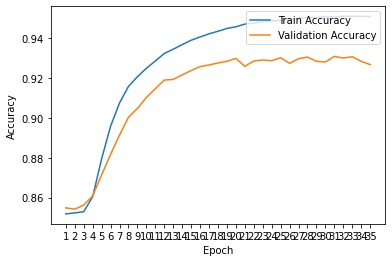

  0%|                                                                                         | 0/6040 [00:00<?, ?it/s]

{'h_len': 28, 'lr_xu': 0.099, 'lr_yi': 0.066, 'lr_bi': 0.065, 'l2_xu': 0.001, 'l2_yi': 0.001, 'l2_bi': 0.006}
Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [08:09<00:00, 12.33it/s]


epoch: 1
| epoch   # 01 :  train_objective : -3.329e+05    train_percent_right : 0.8527    validation_objective : -2.059e+03  validation_percent_right : 0.855
epoch: 2
| epoch   # 02 :  train_objective : -2.52e+05     train_percent_right : 0.8967    validation_objective : -1.763e+03  validation_percent_right : 0.88
epoch: 3
| epoch   # 03 :  train_objective : -1.982e+05    train_percent_right : 0.922     validation_objective : -1.497e+03  validation_percent_right : 0.9015
epoch: 4
| epoch   # 04 :  train_objective : -1.669e+05    train_percent_right : 0.9358    validation_objective : -1.368e+03  validation_percent_right : 0.9151
epoch: 5
| epoch   # 05 :  train_objective : -1.471e+05    train_percent_right : 0.9441    validation_objective : -1.352e+03  validation_percent_right : 0.9171
epoch: 6
| epoch   # 06 :  train_objective : -1.349e+05    train_percent_right : 0.9492    validation_objective : -1.402e+03  validation_percent_right : 0.9147
epoch: 7
| epoch   # 07 :  train_objective 

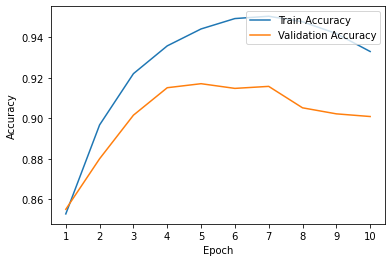

{'h_len': 36, 'lr_xu': 0.014, 'lr_yi': 0.098, 'lr_bi': 0.031, 'l2_xu': 0.002, 'l2_yi': 0.007, 'l2_bi': 0.004}


  0%|                                                                                         | 0/6040 [00:00<?, ?it/s]

Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [07:59<00:00, 12.61it/s]


epoch: 1
| epoch   # 01 :  train_objective : -3.413e+05    train_percent_right : 0.8518    validation_objective : -2.065e+03  validation_percent_right : 0.8561
epoch: 2
| epoch   # 02 :  train_objective : -3.329e+05    train_percent_right : 0.8526    validation_objective : -2.039e+03  validation_percent_right : 0.8558
epoch: 3
| epoch   # 03 :  train_objective : -3.23e+05     train_percent_right : 0.8572    validation_objective : -2.024e+03  validation_percent_right : 0.8565
epoch: 4
| epoch   # 04 :  train_objective : -2.893e+05    train_percent_right : 0.8765    validation_objective : -1.927e+03  validation_percent_right : 0.8664
epoch: 5
| epoch   # 05 :  train_objective : -2.588e+05    train_percent_right : 0.8925    validation_objective : -1.811e+03  validation_percent_right : 0.8796
epoch: 6
| epoch   # 06 :  train_objective : -2.357e+05    train_percent_right : 0.9042    validation_objective : -1.725e+03  validation_percent_right : 0.8886
epoch: 7
| epoch   # 07 :  train_objecti

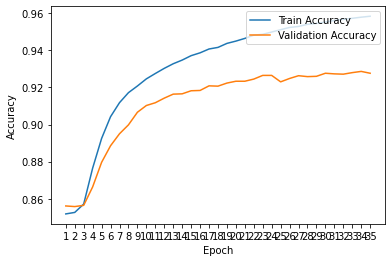

  0%|                                                                                         | 0/6040 [00:00<?, ?it/s]

{'h_len': 28, 'lr_xu': 0.052, 'lr_yi': 0.087, 'lr_bi': 0.071, 'l2_xu': 0.005, 'l2_yi': 0.001, 'l2_bi': 0.009}
Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [07:02<00:00, 14.29it/s]


epoch: 1
| epoch   # 01 :  train_objective : -3.356e+05    train_percent_right : 0.8517    validation_objective : -2.098e+03  validation_percent_right : 0.8536
epoch: 2
| epoch   # 02 :  train_objective : -2.888e+05    train_percent_right : 0.8786    validation_objective : -1.946e+03  validation_percent_right : 0.868
epoch: 3
| epoch   # 03 :  train_objective : -2.261e+05    train_percent_right : 0.9106    validation_objective : -1.653e+03  validation_percent_right : 0.8934
epoch: 4
| epoch   # 04 :  train_objective : -1.932e+05    train_percent_right : 0.9252    validation_objective : -1.475e+03  validation_percent_right : 0.9113
epoch: 5
| epoch   # 05 :  train_objective : -1.709e+05    train_percent_right : 0.935     validation_objective : -1.4e+03  validation_percent_right : 0.9132
epoch: 6
| epoch   # 06 :  train_objective : -1.543e+05    train_percent_right : 0.9423    validation_objective : -1.351e+03  validation_percent_right : 0.9238
epoch: 7
| epoch   # 07 :  train_objective 

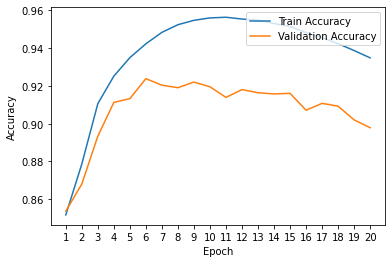

  0%|                                                                                         | 0/6040 [00:00<?, ?it/s]

{'h_len': 32, 'lr_xu': 0.045, 'lr_yi': 0.011, 'lr_bi': 0.031, 'l2_xu': 0.003, 'l2_yi': 0.007, 'l2_bi': 0.006}
Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [06:18<00:00, 15.95it/s]


epoch: 1
| epoch   # 01 :  train_objective : -3.423e+05    train_percent_right : 0.8523    validation_objective : -2.088e+03  validation_percent_right : 0.8551
epoch: 2
| epoch   # 02 :  train_objective : -3.332e+05    train_percent_right : 0.8532    validation_objective : -2.063e+03  validation_percent_right : 0.854
epoch: 3
| epoch   # 03 :  train_objective : -3.314e+05    train_percent_right : 0.8527    validation_objective : -2.052e+03  validation_percent_right : 0.8573
epoch: 4
| epoch   # 04 :  train_objective : -3.299e+05    train_percent_right : 0.8535    validation_objective : -2.057e+03  validation_percent_right : 0.8523
epoch: 5
| epoch   # 05 :  train_objective : -3.195e+05    train_percent_right : 0.8596    validation_objective : -2.026e+03  validation_percent_right : 0.8568
epoch: 6
| epoch   # 06 :  train_objective : -2.983e+05    train_percent_right : 0.8718    validation_objective : -1.967e+03  validation_percent_right : 0.8646
epoch: 7
| epoch   # 07 :  train_objectiv

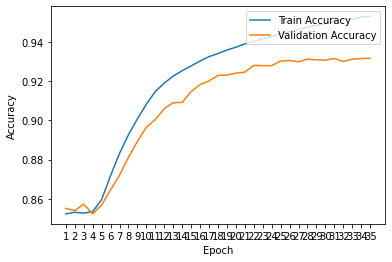

  0%|                                                                                         | 0/6040 [00:00<?, ?it/s]

{'h_len': 28, 'lr_xu': 0.026, 'lr_yi': 0.045, 'lr_bi': 0.026, 'l2_xu': 0.008, 'l2_yi': 0.005, 'l2_bi': 0.003}
Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [05:02<00:00, 20.00it/s]


epoch: 1
| epoch   # 01 :  train_objective : -3.431e+05    train_percent_right : 0.8524    validation_objective : -2.073e+03  validation_percent_right : 0.8578
epoch: 2
| epoch   # 02 :  train_objective : -3.331e+05    train_percent_right : 0.8525    validation_objective : -2.029e+03  validation_percent_right : 0.854
epoch: 3
| epoch   # 03 :  train_objective : -3.252e+05    train_percent_right : 0.8556    validation_objective : -2.012e+03  validation_percent_right : 0.8588
epoch: 4
| epoch   # 04 :  train_objective : -2.952e+05    train_percent_right : 0.8725    validation_objective : -1.926e+03  validation_percent_right : 0.8657
epoch: 5
| epoch   # 05 :  train_objective : -2.642e+05    train_percent_right : 0.889     validation_objective : -1.812e+03  validation_percent_right : 0.8767
epoch: 6
| epoch   # 06 :  train_objective : -2.378e+05    train_percent_right : 0.9025    validation_objective : -1.696e+03  validation_percent_right : 0.8891
epoch: 7
| epoch   # 07 :  train_objectiv

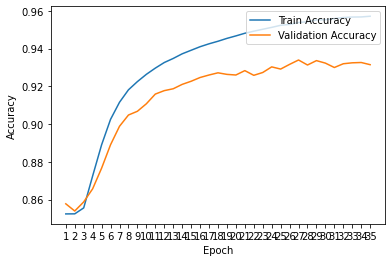

  0%|                                                                                         | 0/6040 [00:00<?, ?it/s]

{'h_len': 24, 'lr_xu': 0.013, 'lr_yi': 0.086, 'lr_bi': 0.05, 'l2_xu': 0.005, 'l2_yi': 0.009, 'l2_bi': 0.008}
Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [04:54<00:00, 20.50it/s]


epoch: 1
| epoch   # 01 :  train_objective : -3.367e+05    train_percent_right : 0.8522    validation_objective : -2.085e+03  validation_percent_right : 0.8548
epoch: 2
| epoch   # 02 :  train_objective : -3.319e+05    train_percent_right : 0.8524    validation_objective : -2.078e+03  validation_percent_right : 0.8556
epoch: 3
| epoch   # 03 :  train_objective : -3.302e+05    train_percent_right : 0.8534    validation_objective : -2.073e+03  validation_percent_right : 0.8541
epoch: 4
| epoch   # 04 :  train_objective : -3.115e+05    train_percent_right : 0.8646    validation_objective : -2.026e+03  validation_percent_right : 0.8606
epoch: 5
| epoch   # 05 :  train_objective : -2.854e+05    train_percent_right : 0.8793    validation_objective : -1.953e+03  validation_percent_right : 0.8707
epoch: 6
| epoch   # 06 :  train_objective : -2.623e+05    train_percent_right : 0.8916    validation_objective : -1.866e+03  validation_percent_right : 0.8785
epoch: 7
| epoch   # 07 :  train_objecti

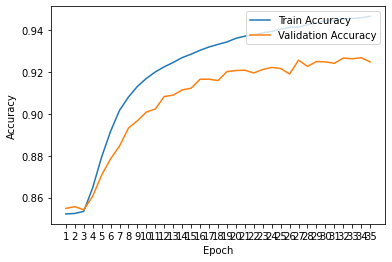

  0%|                                                                                         | 0/6040 [00:00<?, ?it/s]

{'h_len': 28, 'lr_xu': 0.061, 'lr_yi': 0.057, 'lr_bi': 0.097, 'l2_xu': 0.009, 'l2_yi': 0.008, 'l2_bi': 0.006}
Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [05:00<00:00, 20.13it/s]


epoch: 1
| epoch   # 01 :  train_objective : -3.333e+05    train_percent_right : 0.8514    validation_objective : -2.067e+03  validation_percent_right : 0.8536
epoch: 2
| epoch   # 02 :  train_objective : -3.204e+05    train_percent_right : 0.8585    validation_objective : -2.053e+03  validation_percent_right : 0.8561
epoch: 3
| epoch   # 03 :  train_objective : -2.664e+05    train_percent_right : 0.8879    validation_objective : -1.859e+03  validation_percent_right : 0.8765
epoch: 4
| epoch   # 04 :  train_objective : -2.253e+05    train_percent_right : 0.9095    validation_objective : -1.7e+03  validation_percent_right : 0.8925
epoch: 5
| epoch   # 05 :  train_objective : -2.02e+05     train_percent_right : 0.9211    validation_objective : -1.603e+03  validation_percent_right : 0.904
epoch: 6
| epoch   # 06 :  train_objective : -1.868e+05    train_percent_right : 0.9283    validation_objective : -1.541e+03  validation_percent_right : 0.9113
epoch: 7
| epoch   # 07 :  train_objective 

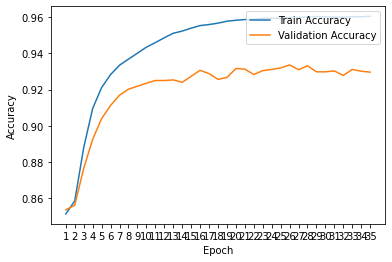

{'h_len': 28, 'lr_xu': 0.097, 'lr_yi': 0.065, 'lr_bi': 0.035, 'l2_xu': 0.004, 'l2_yi': 0.002, 'l2_bi': 0.001}
Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [05:07<00:00, 19.64it/s]


epoch: 1
| epoch   # 01 :  train_objective : -3.342e+05    train_percent_right : 0.8546    validation_objective : -2.026e+03  validation_percent_right : 0.856
epoch: 2
| epoch   # 02 :  train_objective : -2.523e+05    train_percent_right : 0.8953    validation_objective : -1.723e+03  validation_percent_right : 0.8823
epoch: 3
| epoch   # 03 :  train_objective : -2.006e+05    train_percent_right : 0.9196    validation_objective : -1.477e+03  validation_percent_right : 0.9053
epoch: 4
| epoch   # 04 :  train_objective : -1.721e+05    train_percent_right : 0.9324    validation_objective : -1.377e+03  validation_percent_right : 0.9136
epoch: 5
| epoch   # 05 :  train_objective : -1.53e+05     train_percent_right : 0.9406    validation_objective : -1.354e+03  validation_percent_right : 0.9159
epoch: 6
| epoch   # 06 :  train_objective : -1.382e+05    train_percent_right : 0.9476    validation_objective : -1.323e+03  validation_percent_right : 0.9195
epoch: 7
| epoch   # 07 :  train_objectiv

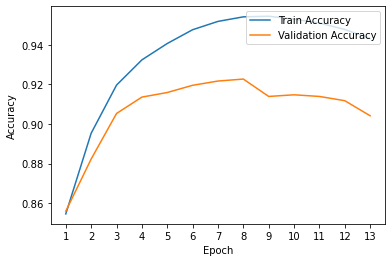

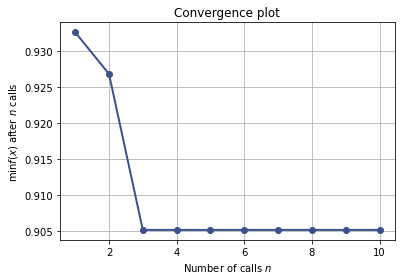

In [16]:
# create validation set
validation_creator = ValidationCreator(CONFIG.validation_creator_sampler_type)
train, validation = validation_creator.get(train.copy())
# add attributes to config
CONFIG.add_attributes(n_users=len(user_map), n_items=len(item_map))
# create matrix factorization object
mf = BPRMatrixFactorizationWithBiasesSGD(CONFIG)
# run the model
run_exp(mf, train.copy(), user_map, item_map, validation)

<b> show the results of tuning

In [17]:
# load the pickl file for the parameters from the tuning
res = skopt.load(r"checkpoint_uniform.pkl")
# conevrt the result to df
sgd_results = pd.DataFrame(res.x_iters, columns = ['lr_xu', 'lr_yi','lr_bi','lambda_xu','lambda_yi','lambda_bi','hidden_dimension_size'])
# put the result column with the correct values
sgd_results['result'] = res.func_vals 
# sort the result by the score from the largest to the smallest
sgd_results = sgd_results.sort_values(by = 'result', ascending= False)
# display the results
sgd_results.style.bar(subset=['result'], align='mid', color=['#86BDEE'])

,lr_xu,lr_yi,lr_bi,lambda_xu,lambda_yi,lambda_bi,hidden_dimension_size,result
0,0.081689,0.026509,0.080172,0.006372,0.005012,0.001900,28,0.932616
5,0.044687,0.011437,0.030780,0.003169,0.007149,0.006490,32,0.931623
6,0.025603,0.045195,0.026401,0.007798,0.004826,0.002871,28,0.931457
8,0.061340,0.056875,0.096505,0.008601,0.007726,0.005857,28,0.929636
3,0.014200,0.097638,0.030949,0.001815,0.006565,0.004442,36,0.927649
1,0.040034,0.022858,0.068580,0.001508,0.007498,0.009447,20,0.926821
7,0.012818,0.085806,0.050478,0.004556,0.009340,0.007545,24,0.924834
9,0.096873,0.064633,0.034840,0.003666,0.002487,0.001141,28,0.913907
4,0.052009,0.087395,0.071228,0.005054,0.001119,0.009480,28,0.909272
2,0.099299,0.065573,0.065049,0.001064,0.001208,0.005723,28,0.905132


<b> define the BPR config by the best parameters with uniform method

In [18]:
BPR_CONFIG_uniform = Config(
    print_metrics=True,
    hidden_dimension=28,
    lr_xu=0.081689,
    lr_yi=0.026509,
    lr_bi=0.080172,
    l2_xu=0.006372,
    l2_yi=0.005012,
    l2_bi=0.001900,
    epochs=31,
    seed=SEED,
    negative_sampler_type=NEGATIVE_SAMPLER_TYPE,
    validation_creator_sampler_type=VALIDATION_CREATOR_SAMPLER_TYPE)

<b> caculate MPR and HIT RATIO at k on validation set

In [19]:
# HYPER_PARAM_SEARCH or manual config- set to TRUE to search the best parameters
HYPER_PARAM_SEARCH = False

# Save and load
MF_SAVE_TRAIN_VALIDATION = False  
MF_LOAD_TRAIN_VALIDATION = True
LOAD_NEGATIVE = True

CONFIG = BPR_CONFIG_uniform

@skopt.utils.use_named_args(space)
def objective(**params):
    mf.set_params(**params)
    print({i: np.round(v, 3) for i, v in mf.__dict__.items() if i in params.keys()})
    return mf.fit(train.copy(), user_map, item_map, validation.copy())

In [20]:
# read the train data ans get the user and item map
train = pd.read_csv(TRAIN_PATH)
train_2, user_map, item_map = preprocess_for_mf(train.copy())
# create validation set
validation_creator = ValidationCreator(CONFIG.validation_creator_sampler_type)
# read the train and validation (we created before)
train_2, validation_2 = validation_creator.get(train_2.copy())
# add attributes to config
CONFIG.add_attributes(n_users=len(user_map), n_items=len(item_map))
# create matrix factorization object
mf = BPRMatrixFactorizationWithBiasesSGD(CONFIG)
# run the model
run_exp(mf, train_2.copy(), user_map, item_map, validation_2)

epoch: 1
| epoch   # 01 :  train_objective : -3.314e+05    train_percent_right : 0.8514    validation_objective : -2.023e+03  validation_percent_right : 0.8553
epoch: 2
| epoch   # 02 :  train_objective : -3.283e+05    train_percent_right : 0.852     validation_objective : -2.019e+03  validation_percent_right : 0.8528
epoch: 3
| epoch   # 03 :  train_objective : -2.996e+05    train_percent_right : 0.869     validation_objective : -1.943e+03  validation_percent_right : 0.8599
epoch: 4
| epoch   # 04 :  train_objective : -2.542e+05    train_percent_right : 0.8929    validation_objective : -1.762e+03  validation_percent_right : 0.8791
epoch: 5
| epoch   # 05 :  train_objective : -2.233e+05    train_percent_right : 0.9084    validation_objective : -1.627e+03  validation_percent_right : 0.895
epoch: 6
| epoch   # 06 :  train_objective : -2.022e+05    train_percent_right : 0.9186    validation_objective : -1.528e+03  validation_percent_right : 0.9026
epoch: 7
| epoch   # 07 :  train_objectiv

<b> Run the final models with uniform </b> <br>
run with the best parameters we got from the tuning

In [26]:
LOAD_NEGATIVE = False
# Final Run on all of the train data
# read the train data ans get the user and item map
train = pd.read_csv(TRAIN_PATH)
train_3, user_map, item_map = preprocess_for_mf(train.copy())
# define the config
config = CONFIG
# create matrix factorization object
mf = BPRMatrixFactorizationWithBiasesSGD(CONFIG)
# fit the data
mf.fit(train_3, user_map, item_map)
# predict for test
mf.predict_on_test_set()

  0%|                                                                                         | 0/6040 [00:00<?, ?it/s]

Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [05:45<00:00, 17.50it/s]


epoch: 1
| epoch   # 01 :  train_objective : -3.334e+05    train_percent_right : 0.8515  
epoch: 2
| epoch   # 02 :  train_objective : -3.289e+05    train_percent_right : 0.8531  
epoch: 3
| epoch   # 03 :  train_objective : -2.966e+05    train_percent_right : 0.8713  
epoch: 4
| epoch   # 04 :  train_objective : -2.533e+05    train_percent_right : 0.8944  
epoch: 5
| epoch   # 05 :  train_objective : -2.219e+05    train_percent_right : 0.9097  
epoch: 6
| epoch   # 06 :  train_objective : -2.03e+05     train_percent_right : 0.9186  
epoch: 7
| epoch   # 07 :  train_objective : -1.88e+05     train_percent_right : 0.9258  
epoch: 8
| epoch   # 08 :  train_objective : -1.773e+05    train_percent_right : 0.9305  
epoch: 9
| epoch   # 09 :  train_objective : -1.686e+05    train_percent_right : 0.9343  
epoch: 10
| epoch   # 10 :  train_objective : -1.62e+05     train_percent_right : 0.9378  
epoch: 11
| epoch   # 11 :  train_objective : -1.56e+05     train_percent_right : 0.9405  
epoch: 1

-------
## Implement BPR tuning with popularity method

<b> define parameters for this running and for the tuning

In [33]:
# define method
NEGATIVE_SAMPLER_TYPE = 'popularity'             #  'uniform' ,'popularity'
VALIDATION_CREATOR_SAMPLER_TYPE = 'popularity'   # 'uniform' ,'popularity'
TEST_PATH = 'PopularityTest.csv'

# define names for files we need
CHECKPOINT_NAME = f"./checkpoint_{NEGATIVE_SAMPLER_TYPE}.pkl"
HYPER_PARAM_FILE_NAME = f"HyperParamResult_{NEGATIVE_SAMPLER_TYPE}.pkl"

# results by types
NEGATIVE_SAMPLES_FILE_NAME = F"all_negative_samples_{NEGATIVE_SAMPLER_TYPE}"
RESULT_FILE_NAME = F"validation_results_negative_sampler_{NEGATIVE_SAMPLER_TYPE}_validation_type_{VALIDATION_CREATOR_SAMPLER_TYPE}.csv"
TRAIN_FILE_NAME = F"train_validation_type_{VALIDATION_CREATOR_SAMPLER_TYPE}.csv"
VALIDATION_FILE_NAME = F"validation_validation_type_{VALIDATION_CREATOR_SAMPLER_TYPE}.csv"
PREDICTION_FILE_NAME = "popularity_205948094_207331752_311244636.csv"

In [34]:
# HYPER_PARAM_SEARCH or manual config- set to TRUE to search the best parameters
HYPER_PARAM_SEARCH = True
# number of parameters, seed and the measure for error
HYPER_PARAM_SEARCH_N_ITER = 10
SEED = 42

# Save and load
MF_SAVE_TRAIN_VALIDATION = True  
MF_LOAD_TRAIN_VALIDATION = False
LOAD_NEGATIVE = False

# hyper parameter tuning
BPR_SPACE = [skopt.space.Real(0.01, 0.1, name='lr_xu', prior='uniform'),
             skopt.space.Real(0.01, 0.1, name='lr_yi', prior='uniform'),
             skopt.space.Real(0.01, 0.1, name='lr_bi', prior='uniform'),
             skopt.space.Real(0.001, 0.01, name='l2_xu', prior='uniform'),
             skopt.space.Real(0.001, 0.01, name='l2_yi', prior='uniform'),
             skopt.space.Real(0.001, 0.01, name='l2_bi', prior='uniform'),
             skopt.space.Categorical([20, 24, 28, 32, 36], name='h_len')]
space = BPR_SPACE

CONFIG = Config(
    lr_xu=0.05,
    lr_yi=0.01,
    lr_bi=0.01,
    print_metrics=True,
    hidden_dimension=28,
    l2_xu=0.001,
    l2_yi=0.001,
    l2_bi=0.001,
    epochs=35,
    seed=SEED,
    negative_sampler_type=NEGATIVE_SAMPLER_TYPE,
    validation_creator_sampler_type=VALIDATION_CREATOR_SAMPLER_TYPE)

@skopt.utils.use_named_args(space)
def objective(**params):
    mf.set_params(**params)
    print({i: np.round(v, 3) for i, v in mf.__dict__.items() if i in params.keys()})
    return mf.fit(train.copy(), user_map, item_map, validation.copy())

<b> read file:

In [37]:
# read the csv file (train data)
train = pd.read_csv(TRAIN_PATH)
# appply the preprocess_for_mf function to get train, validation, dictionary for users and dictionary for items
train, user_map, item_map = preprocess_for_mf(train.copy())

<b> "turn on" tuning and run all the model

  0%|                                                                                 | 3/6040 [00:00<03:49, 26.28it/s]

Creating train & validation sets


  0%|                                                                                         | 0/6040 [00:00<?, ?it/s]

{'h_len': 28, 'lr_xu': 0.082, 'lr_yi': 0.027, 'lr_bi': 0.08, 'l2_xu': 0.006, 'l2_yi': 0.005, 'l2_bi': 0.002}
Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [05:37<00:00, 17.90it/s]


epoch: 1
| epoch   # 01 :  train_objective : -6.379e+05    train_percent_right : 0.6195    validation_objective : -3.183e+03  validation_percent_right : 0.7624
epoch: 2
| epoch   # 02 :  train_objective : -4.539e+05    train_percent_right : 0.7837    validation_objective : -2.471e+03  validation_percent_right : 0.8394
epoch: 3
| epoch   # 03 :  train_objective : -3.643e+05    train_percent_right : 0.8359    validation_objective : -2.148e+03  validation_percent_right : 0.8627
epoch: 4
| epoch   # 04 :  train_objective : -3.21e+05     train_percent_right : 0.8592    validation_objective : -2.077e+03  validation_percent_right : 0.8674
epoch: 5
| epoch   # 05 :  train_objective : -2.911e+05    train_percent_right : 0.8753    validation_objective : -2.037e+03  validation_percent_right : 0.8745
epoch: 6
| epoch   # 06 :  train_objective : -2.681e+05    train_percent_right : 0.887     validation_objective : -2.088e+03  validation_percent_right : 0.8667
epoch: 7
| epoch   # 07 :  train_objecti

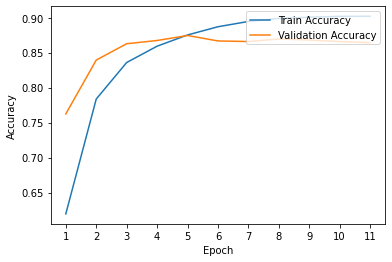

{'h_len': 20, 'lr_xu': 0.04, 'lr_yi': 0.023, 'lr_bi': 0.069, 'l2_xu': 0.002, 'l2_yi': 0.007, 'l2_bi': 0.009}
Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [06:06<00:00, 16.47it/s]


epoch: 1
| epoch   # 01 :  train_objective : -6.429e+05    train_percent_right : 0.6113    validation_objective : -3.245e+03  validation_percent_right : 0.7608
epoch: 2
| epoch   # 02 :  train_objective : -5.871e+05    train_percent_right : 0.6827    validation_objective : -3.041e+03  validation_percent_right : 0.7964
epoch: 3
| epoch   # 03 :  train_objective : -4.652e+05    train_percent_right : 0.7771    validation_objective : -2.515e+03  validation_percent_right : 0.8425
epoch: 4
| epoch   # 04 :  train_objective : -3.988e+05    train_percent_right : 0.8181    validation_objective : -2.28e+03  validation_percent_right : 0.8568
epoch: 5
| epoch   # 05 :  train_objective : -3.598e+05    train_percent_right : 0.8396    validation_objective : -2.149e+03  validation_percent_right : 0.8694
epoch: 6
| epoch   # 06 :  train_objective : -3.343e+05    train_percent_right : 0.8537    validation_objective : -2.096e+03  validation_percent_right : 0.8671
epoch: 7
| epoch   # 07 :  train_objectiv

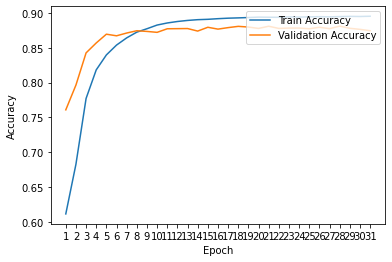

  0%|                                                                                         | 0/6040 [00:00<?, ?it/s]

{'h_len': 28, 'lr_xu': 0.099, 'lr_yi': 0.066, 'lr_bi': 0.065, 'l2_xu': 0.001, 'l2_yi': 0.001, 'l2_bi': 0.006}
Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [04:56<00:00, 20.37it/s]


epoch: 1
| epoch   # 01 :  train_objective : -4.748e+05    train_percent_right : 0.7687    validation_objective : -2.523e+03  validation_percent_right : 0.8298
epoch: 2
| epoch   # 02 :  train_objective : -5.018e+05    train_percent_right : 0.8222    validation_objective : -6.291e+03  validation_percent_right : 0.777
epoch: 3


<ipython-input-25-0418ef616f53>:169: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(prediction)


| epoch   # 03 :  train_objective : -inf          train_percent_right : 0.5683    validation_objective : -inf     validation_percent_right : 0.5661
epoch: 4
| epoch   # 04 :  train_objective : -inf          train_percent_right : 0.5206    validation_objective : -inf     validation_percent_right : 0.5268
epoch: 5
| epoch   # 05 :  train_objective : -inf          train_percent_right : 0.5152    validation_objective : -inf     validation_percent_right : 0.5139
epoch: 6
| epoch   # 06 :  train_objective : -inf          train_percent_right : 0.513     validation_objective : -inf     validation_percent_right : 0.5222
epoch: 7
| epoch   # 07 :  train_objective : -inf          train_percent_right : 0.514     validation_objective : -inf     validation_percent_right : 0.5127
epoch: 8
| epoch   # 08 :  train_objective : -inf          train_percent_right : 0.5148    validation_objective : -inf     validation_percent_right : 0.5048
epoch: 9
| epoch   # 09 :  train_objective : -inf          train_pe

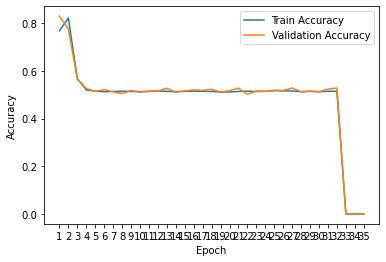

  0%|                                                                                         | 0/6040 [00:00<?, ?it/s]

{'h_len': 36, 'lr_xu': 0.014, 'lr_yi': 0.098, 'lr_bi': 0.031, 'l2_xu': 0.002, 'l2_yi': 0.007, 'l2_bi': 0.004}
Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [06:06<00:00, 16.48it/s]


epoch: 1
| epoch   # 01 :  train_objective : -6.393e+05    train_percent_right : 0.6172    validation_objective : -3.184e+03  validation_percent_right : 0.7733
epoch: 2
| epoch   # 02 :  train_objective : -5.463e+05    train_percent_right : 0.7195    validation_objective : -2.877e+03  validation_percent_right : 0.8164
epoch: 3
| epoch   # 03 :  train_objective : -4.379e+05    train_percent_right : 0.7978    validation_objective : -2.48e+03  validation_percent_right : 0.8526
epoch: 4
| epoch   # 04 :  train_objective : -3.875e+05    train_percent_right : 0.8277    validation_objective : -2.291e+03  validation_percent_right : 0.869
epoch: 5
| epoch   # 05 :  train_objective : -3.551e+05    train_percent_right : 0.8459    validation_objective : -2.205e+03  validation_percent_right : 0.8715
epoch: 6
| epoch   # 06 :  train_objective : -3.353e+05    train_percent_right : 0.8563    validation_objective : -2.131e+03  validation_percent_right : 0.8788
epoch: 7
| epoch   # 07 :  train_objective

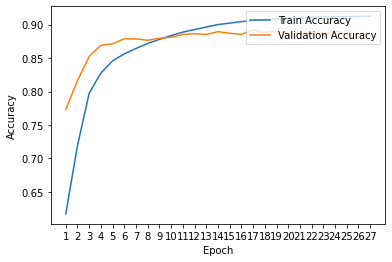

  0%|                                                                                         | 0/6040 [00:00<?, ?it/s]

{'h_len': 28, 'lr_xu': 0.052, 'lr_yi': 0.087, 'lr_bi': 0.071, 'l2_xu': 0.005, 'l2_yi': 0.001, 'l2_bi': 0.009}
Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [05:23<00:00, 18.68it/s]


epoch: 1
| epoch   # 01 :  train_objective : -5.398e+05    train_percent_right : 0.7206    validation_objective : -2.821e+03  validation_percent_right : 0.8157
epoch: 2
| epoch   # 02 :  train_objective : -3.62e+05     train_percent_right : 0.8371    validation_objective : -2.262e+03  validation_percent_right : 0.8449
epoch: 3
| epoch   # 03 :  train_objective : -3.465e+05    train_percent_right : 0.855     validation_objective : -3.049e+03  validation_percent_right : 0.8224
epoch: 4


<ipython-input-25-0418ef616f53>:169: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(prediction)


| epoch   # 04 :  train_objective : -inf          train_percent_right : 0.7845    validation_objective : -inf     validation_percent_right : 0.7285
epoch: 5
| epoch   # 05 :  train_objective : -inf          train_percent_right : 0.6242    validation_objective : -inf     validation_percent_right : 0.6051
epoch: 6
| epoch   # 06 :  train_objective : -inf          train_percent_right : 0.5989    validation_objective : -inf     validation_percent_right : 0.5772
epoch: 7
| epoch   # 07 :  train_objective : -inf          train_percent_right : 0.5566    validation_objective : -inf     validation_percent_right : 0.5515
epoch: 8
| epoch   # 08 :  train_objective : -inf          train_percent_right : 0.5356    validation_objective : -inf     validation_percent_right : 0.5323


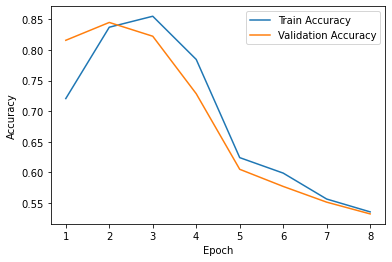

  0%|                                                                                         | 0/6040 [00:00<?, ?it/s]

{'h_len': 32, 'lr_xu': 0.045, 'lr_yi': 0.011, 'lr_bi': 0.031, 'l2_xu': 0.003, 'l2_yi': 0.007, 'l2_bi': 0.006}
Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [06:19<00:00, 15.90it/s]


epoch: 1
| epoch   # 01 :  train_objective : -6.4e+05      train_percent_right : 0.6159    validation_objective : -3.21e+03  validation_percent_right : 0.778
epoch: 2
| epoch   # 02 :  train_objective : -6.366e+05    train_percent_right : 0.6212    validation_objective : -3.2e+03  validation_percent_right : 0.7662
epoch: 3
| epoch   # 03 :  train_objective : -5.619e+05    train_percent_right : 0.7076    validation_objective : -2.909e+03  validation_percent_right : 0.819
epoch: 4
| epoch   # 04 :  train_objective : -4.778e+05    train_percent_right : 0.7701    validation_objective : -2.548e+03  validation_percent_right : 0.8422
epoch: 5
| epoch   # 05 :  train_objective : -4.157e+05    train_percent_right : 0.8097    validation_objective : -2.309e+03  validation_percent_right : 0.8632
epoch: 6
| epoch   # 06 :  train_objective : -3.753e+05    train_percent_right : 0.8325    validation_objective : -2.199e+03  validation_percent_right : 0.8656
epoch: 7
| epoch   # 07 :  train_objective : 

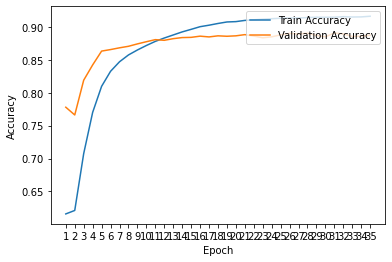

{'h_len': 28, 'lr_xu': 0.026, 'lr_yi': 0.045, 'lr_bi': 0.026, 'l2_xu': 0.008, 'l2_yi': 0.005, 'l2_bi': 0.003}
Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [06:02<00:00, 16.65it/s]


epoch: 1
| epoch   # 01 :  train_objective : -6.394e+05    train_percent_right : 0.6167    validation_objective : -3.192e+03  validation_percent_right : 0.7752
epoch: 2
| epoch   # 02 :  train_objective : -5.635e+05    train_percent_right : 0.7058    validation_objective : -2.935e+03  validation_percent_right : 0.8123
epoch: 3
| epoch   # 03 :  train_objective : -4.419e+05    train_percent_right : 0.7933    validation_objective : -2.43e+03  validation_percent_right : 0.8533
epoch: 4
| epoch   # 04 :  train_objective : -3.818e+05    train_percent_right : 0.8281    validation_objective : -2.216e+03  validation_percent_right : 0.8662
epoch: 5
| epoch   # 05 :  train_objective : -3.46e+05     train_percent_right : 0.8485    validation_objective : -2.133e+03  validation_percent_right : 0.8685
epoch: 6
| epoch   # 06 :  train_objective : -3.219e+05    train_percent_right : 0.8615    validation_objective : -2.066e+03  validation_percent_right : 0.8719
epoch: 7
| epoch   # 07 :  train_objectiv

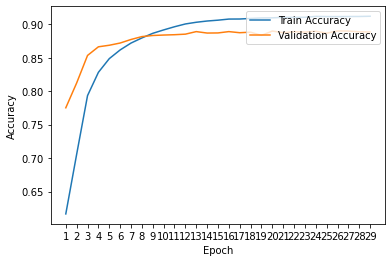

  0%|                                                                                         | 0/6040 [00:00<?, ?it/s]

{'h_len': 24, 'lr_xu': 0.013, 'lr_yi': 0.086, 'lr_bi': 0.05, 'l2_xu': 0.005, 'l2_yi': 0.009, 'l2_bi': 0.008}
Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [05:09<00:00, 19.54it/s]


epoch: 1
| epoch   # 01 :  train_objective : -6.416e+05    train_percent_right : 0.6137    validation_objective : -3.234e+03  validation_percent_right : 0.7669
epoch: 2
| epoch   # 02 :  train_objective : -5.864e+05    train_percent_right : 0.6833    validation_objective : -3.06e+03  validation_percent_right : 0.8022
epoch: 3
| epoch   # 03 :  train_objective : -4.8e+05      train_percent_right : 0.7705    validation_objective : -2.66e+03  validation_percent_right : 0.8411
epoch: 4
| epoch   # 04 :  train_objective : -4.204e+05    train_percent_right : 0.809     validation_objective : -2.476e+03  validation_percent_right : 0.8571
epoch: 5
| epoch   # 05 :  train_objective : -3.883e+05    train_percent_right : 0.8279    validation_objective : -2.373e+03  validation_percent_right : 0.8642
epoch: 6
| epoch   # 06 :  train_objective : -3.669e+05    train_percent_right : 0.8396    validation_objective : -2.309e+03  validation_percent_right : 0.8717
epoch: 7
| epoch   # 07 :  train_objective

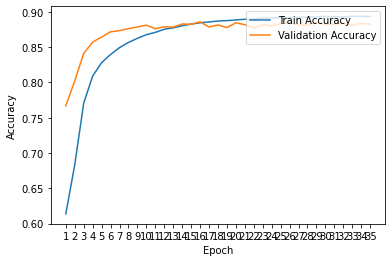

  0%|                                                                                         | 0/6040 [00:00<?, ?it/s]

{'h_len': 28, 'lr_xu': 0.061, 'lr_yi': 0.057, 'lr_bi': 0.097, 'l2_xu': 0.009, 'l2_yi': 0.008, 'l2_bi': 0.006}
Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [05:29<00:00, 18.31it/s]


epoch: 1
| epoch   # 01 :  train_objective : -6.063e+05    train_percent_right : 0.6585    validation_objective : -3.101e+03  validation_percent_right : 0.7887
epoch: 2
| epoch   # 02 :  train_objective : -4.087e+05    train_percent_right : 0.8106    validation_objective : -2.368e+03  validation_percent_right : 0.8493
epoch: 3
| epoch   # 03 :  train_objective : -3.399e+05    train_percent_right : 0.8505    validation_objective : -2.202e+03  validation_percent_right : 0.8626
epoch: 4
| epoch   # 04 :  train_objective : -3.041e+05    train_percent_right : 0.8702    validation_objective : -2.147e+03  validation_percent_right : 0.8684
epoch: 5
| epoch   # 05 :  train_objective : -2.787e+05    train_percent_right : 0.8839    validation_objective : -2.134e+03  validation_percent_right : 0.8738
epoch: 6
| epoch   # 06 :  train_objective : -2.61e+05     train_percent_right : 0.8934    validation_objective : -2.143e+03  validation_percent_right : 0.8805
epoch: 7
| epoch   # 07 :  train_objecti

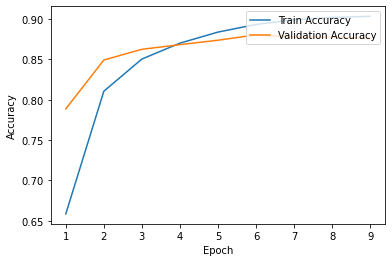

  0%|                                                                                         | 0/6040 [00:00<?, ?it/s]

{'h_len': 28, 'lr_xu': 0.097, 'lr_yi': 0.065, 'lr_bi': 0.035, 'l2_xu': 0.004, 'l2_yi': 0.002, 'l2_bi': 0.001}
Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [05:47<00:00, 17.40it/s]


epoch: 1
| epoch   # 01 :  train_objective : -4.772e+05    train_percent_right : 0.7678    validation_objective : -2.539e+03  validation_percent_right : 0.8343
epoch: 2
| epoch   # 02 :  train_objective : -3.631e+05    train_percent_right : 0.8414    validation_objective : -2.679e+03  validation_percent_right : 0.8262
epoch: 3


<ipython-input-25-0418ef616f53>:169: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(prediction)


| epoch   # 03 :  train_objective : -inf          train_percent_right : 0.6965    validation_objective : -inf     validation_percent_right : 0.6594
epoch: 4
| epoch   # 04 :  train_objective : -inf          train_percent_right : 0.5676    validation_objective : -inf     validation_percent_right : 0.5575
epoch: 5
| epoch   # 05 :  train_objective : -inf          train_percent_right : 0.5279    validation_objective : -inf     validation_percent_right : 0.5257
epoch: 6
| epoch   # 06 :  train_objective : -inf          train_percent_right : 0.5196    validation_objective : -inf     validation_percent_right : 0.5262
epoch: 7
| epoch   # 07 :  train_objective : -inf          train_percent_right : 0.5194    validation_objective : -inf     validation_percent_right : 0.5164
epoch: 8
| epoch   # 08 :  train_objective : -inf          train_percent_right : 0.5193    validation_objective : -inf     validation_percent_right : 0.5272
epoch: 9
| epoch   # 09 :  train_objective : -inf          train_pe

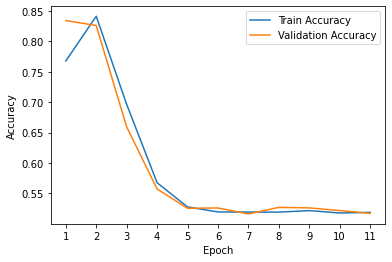

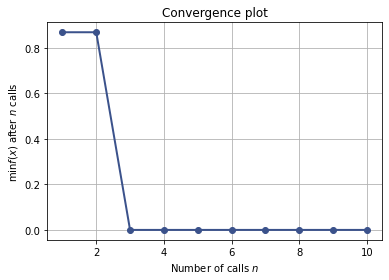

In [38]:
# create validation set
validation_creator = ValidationCreator(CONFIG.validation_creator_sampler_type)
train, validation = validation_creator.get(train.copy())
# add attributes to config
CONFIG.add_attributes(n_users=len(user_map), n_items=len(item_map))
# create matrix factorization object
mf = BPRMatrixFactorizationWithBiasesSGD(CONFIG)
# run the model
run_exp(mf, train.copy(), user_map, item_map, validation)

<b> show the results of tuning

In [39]:
# load the pickl efile for the parameters from the tuning
res = skopt.load(r"checkpoint_popularity.pkl")
# conevrt the result to df
sgd_results = pd.DataFrame(res.x_iters, columns = ['lr_xu', 'lr_yi','lr_bi','lambda_xu','lambda_yi','lambda_bi','hidden_dimension_size'])
# put the result column with the correct values
sgd_results['result'] = res.func_vals 
# sort the result by the score from the largest to the smallest
sgd_results = sgd_results.sort_values(by = 'result', ascending= False)
# display the results
sgd_results.style.bar(subset=['result'], align='mid', color=['#86BDEE'])

,lr_xu,lr_yi,lr_bi,lambda_xu,lambda_yi,lambda_bi,hidden_dimension_size,result
6,0.025603,0.045195,0.026401,0.007798,0.004826,0.002871,28,0.889735
5,0.044687,0.011437,0.030780,0.003169,0.007149,0.006490,32,0.887252
3,0.014200,0.097638,0.030949,0.001815,0.006565,0.004442,36,0.886258
7,0.012818,0.085806,0.050478,0.004556,0.009340,0.007545,24,0.882450
1,0.040034,0.022858,0.068580,0.001508,0.007498,0.009447,20,0.877815
8,0.061340,0.056875,0.096505,0.008601,0.007726,0.005857,28,0.877815
0,0.081689,0.026509,0.080172,0.006372,0.005012,0.001900,28,0.868046
4,0.052009,0.087395,0.071228,0.005054,0.001119,0.009480,28,0.577152
9,0.096873,0.064633,0.034840,0.003666,0.002487,0.001141,28,0.526325
2,0.099299,0.065573,0.065049,0.001064,0.001208,0.005723,28,0.000000


<b> define the BPR config by the best parameters with popularity method

In [40]:
BPR_CONFIG_popularity = Config(
    print_metrics=True,
    hidden_dimension=28,
    lr_xu=0.025603,
    lr_yi=0.045195,
    lr_bi=0.026401,
    l2_xu=0.007798,
    l2_yi=0.004826,
    l2_bi=0.002871,
    epochs=26,
    seed=SEED,
    negative_sampler_type=NEGATIVE_SAMPLER_TYPE,
    validation_creator_sampler_type=VALIDATION_CREATOR_SAMPLER_TYPE)

<b> caculate MPR and HIT RATIO at k on validation set

In [41]:
# HYPER_PARAM_SEARCH or manual config- set to TRUE to search the best parameters
HYPER_PARAM_SEARCH = False

# Save and load
MF_SAVE_TRAIN_VALIDATION = False  
MF_LOAD_TRAIN_VALIDATION = True
LOAD_NEGATIVE = True

CONFIG = BPR_CONFIG_popularity

@skopt.utils.use_named_args(space)
def objective(**params):
    mf.set_params(**params)
    print({i: np.round(v, 3) for i, v in mf.__dict__.items() if i in params.keys()})
    return mf.fit(train.copy(), user_map, item_map, validation.copy())

In [43]:
# read the csv file (train data)
train = pd.read_csv(TRAIN_PATH)
# appply the preprocess_for_mf function to get train, validation, dictionary for users and dictionary for items
train_4, user_map, item_map = preprocess_for_mf(train.copy())
# create validation set
validation_creator = ValidationCreator(CONFIG.validation_creator_sampler_type)
# read the train and validation (we created before)
train_4, validation_4 = validation_creator.get(train_4.copy())
# add attributes to config
CONFIG.add_attributes(n_users=len(user_map), n_items=len(item_map))
# create matrix factorization object
mf = BPRMatrixFactorizationWithBiasesSGD(CONFIG)
# run the model
run_exp(mf, train_4.copy(), user_map, item_map, validation_4)

epoch: 1
| epoch   # 01 :  train_objective : -6.396e+05    train_percent_right : 0.6164    validation_objective : -3.203e+03  validation_percent_right : 0.7725
epoch: 2
| epoch   # 02 :  train_objective : -5.578e+05    train_percent_right : 0.713     validation_objective : -2.906e+03  validation_percent_right : 0.8219
epoch: 3
| epoch   # 03 :  train_objective : -4.386e+05    train_percent_right : 0.7957    validation_objective : -2.407e+03  validation_percent_right : 0.8523
epoch: 4
| epoch   # 04 :  train_objective : -3.812e+05    train_percent_right : 0.8285    validation_objective : -2.229e+03  validation_percent_right : 0.8646
epoch: 5
| epoch   # 05 :  train_objective : -3.462e+05    train_percent_right : 0.8486    validation_objective : -2.135e+03  validation_percent_right : 0.8728
epoch: 6
| epoch   # 06 :  train_objective : -3.226e+05    train_percent_right : 0.8609    validation_objective : -2.071e+03  validation_percent_right : 0.8717
epoch: 7
| epoch   # 07 :  train_objecti

<b> Run the final models with popularity </b> <br>
run with the best parameters we got from the tuning

In [44]:
LOAD_NEGATIVE = False
# Final Run on all of the train data
# read the train data ans get the user and item map
train = pd.read_csv(TRAIN_PATH)
train_5, user_map, item_map = preprocess_for_mf(train.copy())
# define the config
config = CONFIG
# create matrix factorization object
mf = BPRMatrixFactorizationWithBiasesSGD(CONFIG)
# fit the data
mf.fit(train_5, user_map, item_map)
# predict for test
mf.predict_on_test_set()

  0%|                                                                                         | 0/6040 [00:00<?, ?it/s]

Creating negative samples


100%|██████████████████████████████████████████████████████████████████████████████| 6040/6040 [05:34<00:00, 18.04it/s]


epoch: 1
| epoch   # 01 :  train_objective : -6.422e+05    train_percent_right : 0.6183  
epoch: 2
| epoch   # 02 :  train_objective : -5.575e+05    train_percent_right : 0.7148  
epoch: 3
| epoch   # 03 :  train_objective : -4.413e+05    train_percent_right : 0.7955  
epoch: 4
| epoch   # 04 :  train_objective : -3.813e+05    train_percent_right : 0.8302  
epoch: 5
| epoch   # 05 :  train_objective : -3.44e+05     train_percent_right : 0.8509  
epoch: 6
| epoch   # 06 :  train_objective : -3.207e+05    train_percent_right : 0.8632  
epoch: 7
| epoch   # 07 :  train_objective : -3.031e+05    train_percent_right : 0.8728  
epoch: 8
| epoch   # 08 :  train_objective : -2.877e+05    train_percent_right : 0.881   
epoch: 9
| epoch   # 09 :  train_objective : -2.753e+05    train_percent_right : 0.8875  
epoch: 10
| epoch   # 10 :  train_objective : -2.652e+05    train_percent_right : 0.8926  
epoch: 11
| epoch   # 11 :  train_objective : -2.564e+05    train_percent_right : 0.8974  
epoch: 1